## Imports ##

In [1]:
import numpy as np
import scipy
import rqcopt as oc
import matplotlib.pyplot as plt
from scipy import optimize
import ctypes
import numpy as np

## Import C dynamic libraries ##

In [2]:
rqcopt_dynlib_path = "../../../rqcopt_hpc/build/rqcopt_lib.dylib"
rqcopt_lib = ctypes.CDLL(rqcopt_dynlib_path)
print(type(rqcopt_lib))

# Define the structure for truncated_cg_params
class TruncatedCGParams(ctypes.Structure):
    _fields_ = [("maxiter", ctypes.c_int),
                ("abstol", ctypes.c_double),
                ("reltol", ctypes.c_double)]

# Define the structure for rtr_params
class RTRParams(ctypes.Structure):
    _fields_ = [("tcg_params", TruncatedCGParams),
                ("rho_trust", ctypes.c_double),
                ("radius_init", ctypes.c_double),
                ("maxradius", ctypes.c_double),
                ("g_func", ctypes.c_void_p),
                ("g_data", ctypes.c_void_p),
                ("g_iter", ctypes.POINTER(ctypes.c_double))]

# Define the function signature for target_func
target_func = ctypes.CFUNCTYPE(ctypes.c_double, ctypes.POINTER(ctypes.c_double), ctypes.c_void_p)

# Define the optimize_brickwall_circuit function signature
optimize_brickwall_circuit = rqcopt_lib.optimize_brickwall_circuit_compact
optimize_brickwall_circuit.restype = None
optimize_brickwall_circuit.argtypes = [
    ctypes.c_void_p,                                  # udata
    ctypes.POINTER(ctypes.c_double * 32),             # Vlist_start
    ctypes.c_int,                                     # nlayers
    ctypes.c_int,                                     # L
    ctypes.POINTER(ctypes.POINTER(ctypes.c_int)),     # perms
    ctypes.c_int,                                     # niter
    ctypes.POINTER(ctypes.c_double),                  # f_iter
    ctypes.POINTER(ctypes.c_double * 32)              # Vlist_opt
]

<class 'ctypes.CDLL'>


## Function definitions ##

In [3]:
def unitary4_from_list(values):
    assert len(values) == 16
    hermit = np.zeros((4,4), dtype=complex)
    for i in range(4):
        hermit[i,i] = values[i]
    k = 4
    for i in range(4):
        for j in range(i+1, 4):
            hermit[i, j] += values[k] + 1.0j*values[k+1] 
            hermit[j, i] += values[k] - 1.0j*values[k+1]
            k += 2

    _, evec = np.linalg.eigh(hermit)
    return evec

def trotterized_time_evolution(L: int, hloc, perm_set, method: oc.SplittingMethod, dt: float, nsteps: int):
    """
    Compute the numeric ODE flow operator of the quantum time evolution
    based on the provided splitting method.
    """
    Vlist = []
    perms = []
    for i, c in zip(method.indices, method.coeffs):
        Vlist.append(scipy.linalg.expm(-1j*c*dt*hloc[i]))
        perms.append(perm_set[i])
    V = oc.brickwall_unitary(Vlist, L, perms)
    return np.linalg.matrix_power(V, nsteps)

def construct_fermi_hubbard_local_kinetic_term(J):
    return -J * np.array([[0., 0., 0., 0.], [0., 0., 1., 0.], [0., 1., 0., 0.], [0., 0., 0., 0.]]);

def construct_fermi_hubbard_local_interaction_term(U):
    n_spin = np.array([[0., 0.], [0., 1.]])
    return U * np.kron(n_spin, n_spin);

def fsim_gate(theta, phi):
    a = np.cos(theta)
    b = - 1.0j * np.sin(theta)
    c = np.exp(1.0j * phi)
    return np.array([[1., 0., 0., 0.], [0., a, b, 0.], [0., b, a, 0.], [0., 0., 0., c]])

def acting_two_qubit_gate(U, idx1, idx2, total_qubits):
    if idx2 < idx1:
        U = np.reshape(U, (2,2,2,2))
        U = np.transpose(U, (1,0, 3,2))
        U = np.reshape(U, (4,4))
        idx_temp = idx1
        idx1 = idx2
        idx2 = idx_temp
    mat = np.kron(U,np.eye(2**(total_qubits - 2)))
    print(mat.shape)
    mat = np.reshape(mat, (2,2,2**idx1, 2**(idx2 - idx1 - 1), 2**(total_qubits - idx2 - 1),2,2,2**idx1, 2**(idx2 - idx1 - 1), 2**(total_qubits - idx2 - 1)))
    mat = np.transpose(mat, (2,0,3,1,4, 7,5,8,6,9))
    mat = np.reshape(mat, (2**total_qubits, 2**total_qubits))
    return mat

def simulate_optimized_gate(vlist, perms, coeffs):
    n_qubits = np.shape(perms[0])[0]
    mat = np.eye(2**n_qubits)
    print(mat.shape)
    print(coeffs)
    for v_idx in coeffs:
        V = vlist[v_idx]
        print(V.shape)
        perm = perms[v_idx]
        for i in range(int(len(perm) / 2)):
            mat = acting_two_qubit_gate(V, perm[2*i], perm[2*i + 1], n_qubits) @ mat
    return mat

## Initial values ##

In [4]:
L = 4
J = 1.
U = 4
t = 1/8
strang = oc.SplittingMethod.suzuki(3, 3)
indices_start_n9, coeffs_start_n9 = oc.merge_layers(2*strang.indices, 2*strang.coeffs)
coeffs_start_n9 = [0.5*c for c in coeffs_start_n9]
method_start = oc.SplittingMethod(3, indices_start_n9, coeffs_start_n9, 2)
nsteps = 50

horz_even_sites = np.array(range(2*L))
horz_odd_sites = np.roll(range(L*2), -1)
horz_odd_sites[[L - 1, L*2 -1]] = horz_odd_sites[[L*2 - 1, L -1]]
vert_sites = np.array([[i, i + L] for i in range(L)]).flatten()

perm_set = [
    horz_even_sites, 
    np.argsort(horz_odd_sites).tolist(), 
    np.argsort(vert_sites).tolist(),
    horz_even_sites, 
    np.argsort(horz_odd_sites).tolist(), 
    np.argsort(vert_sites).tolist()]

def get_perm_set(L):
    horz_even_sites = np.array(range(2*L))
    horz_odd_sites = np.roll(range(L*2), -1)
    horz_odd_sites[[L - 1, L*2 -1]] = horz_odd_sites[[L*2 - 1, L -1]]
    vert_sites = np.array([[i, i + L] for i in range(L)]).flatten()
    return [
        horz_even_sites, 
        np.argsort(horz_odd_sites).tolist(), 
        np.argsort(vert_sites).tolist(),
        horz_even_sites, 
        np.argsort(horz_odd_sites).tolist(), 
        np.argsort(vert_sites).tolist()]



bounds_pi = (0, 2 * np.pi)
bounds = [bounds_pi for i in range(4)]

## Reference Hamiltonian ##

In [5]:
def reference_hamiltonian(J, U, t, L):
    H = np.zeros((2**(2*L), 2**(2*L)))

    n_spin = np.eye(2)
    n_spin[0,0] = 0
    n_spin_big = np.kron(n_spin, np.kron(np.eye(2 ** (L - 1)), n_spin))
    for i in range (L):
        H += U * np.kron(np.eye(2 ** i), np.kron(n_spin_big, np.eye(2 ** (L - i - 1))))

    ### LOCAL KINETIC TERM
    hloc_horz = construct_fermi_hubbard_local_kinetic_term(J)
    hloc_vert = construct_fermi_hubbard_local_interaction_term(U)
    a_i = np.zeros((2,2))
    a_i1 = np.zeros((2,2))
    a_i[1,0] = 1
    a_i1[0,1] = 1
    for i in range (L - 1):
        H += np.kron(np.eye(2 ** i), np.kron(hloc_horz, np.eye(2**(2 * L - i - 2))))
    for i in range (L, 2*L - 1):
        H += np.kron(np.eye(2 ** i), np.kron(hloc_horz, np.eye(2**(2 * L - i - 2))))
    H += -J * np.kron(a_i1, np.kron(np.eye(2**(L - 2)), np.kron(a_i, np.eye(2**(L)))))
    H += -J * np.kron(a_i, np.kron(np.eye(2**(L - 2)), np.kron(a_i1, np.eye(2**(L)))))
    H += -J * np.kron(np.kron(np.eye(2**(L)), a_i1), np.kron(np.eye(2**(L - 2)), a_i))
    H += -J * np.kron(np.kron(np.eye(2**(L)), a_i), np.kron(np.eye(2**(L - 2)), a_i1))
    expiH = scipy.linalg.expm(-1j*H*t)

    print("H.shape:", H.shape)
    return H, expiH

In [6]:
def optimize_fermi_hubbard_in_brickwall_layout(vals):
    hloc_horz = fsim_gate(vals[0], vals[1])
    hloc_vert = fsim_gate(vals[2], vals[3])
    hloc = [hloc_horz, hloc_horz, hloc_vert]
    
    Vlist_start = []
    perms = []
    for i, c in zip(method_start.indices, method_start.coeffs):
        #Vlist_start.append(scipy.linalg.expm(-1j*c*t*hloc[i]))
        Vlist_start.append(hloc[i])
        perms.append(perm_set[i])
    
    #rqcopt_lib.optimize_brickwall_circuit(None, None, Vlist_start, 1, 2 * L, perm_set, None, nsteps, None, None)
    return oc.optimize_brickwall_circuit(2 * L, expiH, Vlist_start, perms, niter=nsteps)

In [7]:
def optimize_fermi_hubbard_in_brickwall_layout_dylib(vals):
    hloc_horz = fsim_gate(vals[0], vals[1])
    hloc_vert = fsim_gate(vals[2], vals[3])
    hloc = [hloc_horz, hloc_horz, hloc_vert]

    Vlist_start = []
    perms = []
    for i, c in zip(method_start.indices, method_start.coeffs):
        Vlist_start.append(scipy.linalg.expm(-1j*c*t*hloc[i]))
        perms.append(perm_set[i])

    Vlist_start = np.array(Vlist_start)
    perms = np.array(perms, dtype='int32')
    params = RTRParams()
    Vlist_opt = np.zeros_like(Vlist_start)
    f_iter = np.zeros(nsteps, dtype=np.float64)
    c_perems = (ctypes.POINTER(ctypes.c_int) * perms.shape[0])()
    for i, row in enumerate(perms):
        c_perems[i] = row.ctypes.data_as(ctypes.POINTER(ctypes.c_int))

    rqcopt_lib.test_function()

    print(Vlist_start[2][3][3])
    print(expiH[255][255])
    
    optimize_brickwall_circuit(
        expiH.ctypes.data_as(ctypes.POINTER(ctypes.c_double * 2)), 
        Vlist_start.ctypes.data_as(ctypes.POINTER(ctypes.c_double * 32)), 
        np.shape(perms)[0], 
        2 * L, 
        c_perems, 
        nsteps, 
        f_iter.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),  
        Vlist_opt.ctypes.data_as(ctypes.POINTER(ctypes.c_double * 32)))
    return f_iter, Vlist_opt
    
# c_vlist, c_f_iter = optimize_fermi_hubbard_in_brickwall_layout_dylib_example()

In [8]:
def optimize_fermi_hubbard_in_brickwall_layout_example():
    Vlist_start = []
    perms = []
    hloc = [hloc_horz, hloc_horz, hloc_vert]
    for i, c in zip(method_start.indices, method_start.coeffs):
        Vlist_start.append(scipy.linalg.expm(-1j*c*t*hloc[i]))
        perms.append(perm_set[i])
    return oc.optimize_brickwall_circuit(2 * L, expiH, Vlist_start, perms, niter=nsteps)

In [6]:
def optimize_fermi_hubbard_in_brickwall_layout_dylib_example(J, U, t, hloc_horz, hloc_vert, splitting, L):
    Vlist_start = []
    perms = []
    hloc = [hloc_horz, hloc_horz, hloc_vert]
    perm_set = get_perm_set(L)
    for i, c in zip(splitting.indices, splitting.coeffs):
        Vlist_start.append(scipy.linalg.expm(-1j*c*t*hloc[i]))
        perms.append(perm_set[i])

    Vlist_start = np.array(Vlist_start)
    perms = np.array(perms, dtype='int32')
    Vlist_opt = np.zeros_like(Vlist_start)
    f_iter = np.zeros(nsteps, dtype=np.float64)
    c_perems = (ctypes.POINTER(ctypes.c_int) * perms.shape[0])()
    for i, row in enumerate(perms):
        c_perems[i] = row.ctypes.data_as(ctypes.POINTER(ctypes.c_int))

    H, expiH = reference_hamiltonian(J, U, t, L)
    
    optimize_brickwall_circuit(
        expiH.ctypes.data_as(ctypes.POINTER(ctypes.c_double * 2)), 
        Vlist_start.ctypes.data_as(ctypes.POINTER(ctypes.c_double * 32)), 
        np.shape(perms)[0], 
        2 * L, 
        c_perems, 
        nsteps, 
        f_iter.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),  
        Vlist_opt.ctypes.data_as(ctypes.POINTER(ctypes.c_double * 32)))
    return Vlist_opt, f_iter

def optimize_fermi_hubbard_in_brickwall_layout_dylib_example_double(J, U, t, hloc_horz, hloc_vert, splitting, L):
    Vlist_start = []
    perms = []
    hloc = [hloc_horz, hloc_horz, hloc_vert, np.eye(4), np.eye(4), np.eye(4)]
    perm_set = get_perm_set(L)
    for i, c in zip(splitting.indices, splitting.coeffs):
        Vlist_start.append(scipy.linalg.expm(-1j*c*t*hloc[i]))
        perms.append(perm_set[i])

    Vlist_start = np.array(Vlist_start)
    perms = np.array(perms, dtype='int32')
    Vlist_opt = np.zeros_like(Vlist_start)
    f_iter = np.zeros(nsteps, dtype=np.float64)
    c_perems = (ctypes.POINTER(ctypes.c_int) * perms.shape[0])()
    for i, row in enumerate(perms):
        c_perems[i] = row.ctypes.data_as(ctypes.POINTER(ctypes.c_int))

    H, expiH = reference_hamiltonian(J, U, t, L)
    
    optimize_brickwall_circuit(
        expiH.ctypes.data_as(ctypes.POINTER(ctypes.c_double * 2)), 
        Vlist_start.ctypes.data_as(ctypes.POINTER(ctypes.c_double * 32)), 
        np.shape(perms)[0], 
        2 * L, 
        c_perems, 
        nsteps, 
        f_iter.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),  
        Vlist_opt.ctypes.data_as(ctypes.POINTER(ctypes.c_double * 32)))
    return Vlist_opt, f_iter

def optimize_fermi_hubbard_in_brickwall_layout_dylib_example_double_ref(J, U, t, hloc_horz, hloc_vert, splitting, L):
    Vlist_start = []
    perms = []
    hloc = [hloc_horz, hloc_horz, hloc_vert, hloc_horz, hloc_horz, hloc_vert]
    perm_set = get_perm_set(L)
    for i, c in zip(splitting.indices, splitting.coeffs):
        Vlist_start.append(scipy.linalg.expm(-1j*c*t*hloc[i]))
        perms.append(perm_set[i])

    Vlist_start = np.array(Vlist_start)
    perms = np.array(perms, dtype='int32')
    Vlist_opt = np.zeros_like(Vlist_start)
    f_iter = np.zeros(nsteps, dtype=np.float64)
    c_perems = (ctypes.POINTER(ctypes.c_int) * perms.shape[0])()
    for i, row in enumerate(perms):
        c_perems[i] = row.ctypes.data_as(ctypes.POINTER(ctypes.c_int))

    H, expiH = reference_hamiltonian(J, U, t, L)
    
    optimize_brickwall_circuit(
        expiH.ctypes.data_as(ctypes.POINTER(ctypes.c_double * 2)), 
        Vlist_start.ctypes.data_as(ctypes.POINTER(ctypes.c_double * 32)), 
        np.shape(perms)[0], 
        2 * L, 
        c_perems, 
        nsteps, 
        f_iter.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),  
        Vlist_opt.ctypes.data_as(ctypes.POINTER(ctypes.c_double * 32)))
    return Vlist_opt, f_iter

In [38]:
def plot_opt(err_ex, Vlist_opt_ex):
    print(f"err_iter before: {err_ex[0]}")
    print(f"err_iter after {len(err_ex)-1} iterations: {err_ex[-1]}")
    print(err_ex)
    plt.semilogy(range(len(err_ex)), err_ex)
    plt.xlabel("iteration")
    plt.ylabel("spectral norm error")
    plt.title(f"optimization progress for a quantum circuit with {len(Vlist_opt_ex)} layers")
    plt.show()

def plot_opt_multiple(err_list, hamiltonian_params, title):
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.title(title)
    markers = ['o', '*', '.', ',', 'x', '+', 's']
    colors = ['blue', 'red', 'green', 'orange', 'black', 'brown', 'grey']
    for i in range(len(hamiltonian_params)):
        print(err_list[i][-1] + 2 ** (2 * L))
        plt.semilogy(range(len(err_list[i])), err_list[i] + 2**(2*L), marker=markers[i], color=colors[i])
    plt.legend([f"({hamiltonian_params[i][0]}, {hamiltonian_params[i][1]}, {hamiltonian_params[i][2]})" for i in range(len(hamiltonian_params))], loc='upper right')
    plt.show()

In [11]:
def optimize_fermi_hubbard_in_brickwall_layout_err(vals):
    Vlist, f_iter, err_iter = optimize_fermi_hubbard_in_brickwall_layout(vals)
    return err_iter[-1]

In [12]:
def number_operator(N):
    mat = np.eye(2**(2*N), dtype=complex)
    create_op = np.array([[0., 0.], [1., 0.]])
    annihilate_op = np.array([[0., 1.], [0., 0.]])
    for i in range(2 * N):
        mat = np.kron(np.eye(int(2**(i))), np.kron(create_op @ annihilate_op, np.eye(int(2**(2 * N-i-1))))) @ mat
        
    return mat

In [13]:
# err, vlist = optimize_fermi_hubbard_in_brickwall_layout_dylib([0.0, 0.0, 0.0, 0.0])

In [42]:
Ux = simulate_optimized_gate(results_vlist[0], perm_set, splitting.indices)
N = number_operator(int(L))
H = reference_hamiltonian(1, 4, 0.5, 4)
np.linalg.norm(Ux @ N - N @ Ux, ord=2)

(256, 256)
[0, 1, 2, 3, 4, 3, 2, 1, 0]
(4, 4)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(4, 4)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(4, 4)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(4, 4)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(4, 4)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(4, 4)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(4, 4)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(4, 4)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(4, 4)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
H.shape: (256, 256)


0.0

In [ ]:
# results = []
# best_config = [0, 0, 0, 0]
# iter = 0
# min_err = 100000.0
# for alpha_1 in np.linspace(0, 2 * np.pi, 4):
#     for beta_1 in np.linspace(0, 2 * np.pi, 4):
#         for alpha_2 in np.linspace(0, 2 * np.pi, 4):
#             for beta_2 in np.linspace(0, 2 * np.pi, 4):
#                 err = optimize_fermi_hubbard_in_brickwall_layout_dylib([alpha_1, beta_1, alpha_2, beta_2])
#                 print("Iteration: " + str(iter))
#                 iter += 1
#                 if err < min_err:
#                     print("New best found:")
#                     print(err)
#                     min_err = err
#                     best_config = [alpha_1, beta_1, alpha_2, beta_2]

# vlist, err = optimize_fermi_hubbard_in_brickwall_layout_dylib_example()


In [ ]:
#plot_opt(err + 256, vlist)

## Optimization ##

In [15]:
hamiltonian_params = [(1,4,1/8), (1,4,1/4), (1,4,1/2), (1,8,1/8), (1,8,1/4), (1,8,1/2)]
H = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])
## SPLTTING METHOD CAN BE CHANGE HERE #
splitting = oc.SplittingMethod.suzuki(6,1)

results_err = []
results_vlist = []
for i in range(len(hamiltonian_params)):
    (J, U, t) = hamiltonian_params[i]
    v_kin = np.kron(H, H)
    v_inter = np.kron(H, H)
    vlist, err = optimize_fermi_hubbard_in_brickwall_layout_dylib_example(J, U, t, v_kin, v_inter, splitting, 4)
    results_err.append(err)
    results_vlist.append(vlist)


IndexError: list index out of range

In [25]:
hamiltonian_params = [(1,4,1/8), (1,4,1/4), (1,4,1/2), (1,8,1/8), (1,8,1/4), (1,8,1/2)]
H = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])
## SPLTTING METHOD CAN BE CHANGE HERE #
splitting = oc.SplittingMethod.suzuki(5,2)
print(splitting.num_terms)
print(splitting.num_layers)
print(splitting.coeffs)


results_err = []
results_vlist = []
for i in range(len(hamiltonian_params)):
    (J, U, t) = hamiltonian_params[i]
    v_kin = construct_fermi_hubbard_local_kinetic_term(J)
    v_inter = construct_fermi_hubbard_local_interaction_term(U)
    vlist, err = optimize_fermi_hubbard_in_brickwall_layout_dylib_example_double(J, U, t, v_kin, v_inter, splitting, 4)
    results_err.append(err)
    results_vlist.append(vlist)

5
41
[0.20724538589718786, 0.20724538589718786, 0.20724538589718786, 0.20724538589718786, 0.4144907717943757, 0.20724538589718786, 0.20724538589718786, 0.20724538589718786, 0.4144907717943757, 0.20724538589718786, 0.20724538589718786, 0.20724538589718786, 0.4144907717943757, 0.20724538589718786, 0.20724538589718786, 0.20724538589718786, -0.12173615769156357, -0.3289815435887514, -0.3289815435887514, -0.3289815435887514, -0.6579630871775028, -0.3289815435887514, -0.3289815435887514, -0.3289815435887514, -0.12173615769156357, 0.20724538589718786, 0.20724538589718786, 0.20724538589718786, 0.4144907717943757, 0.20724538589718786, 0.20724538589718786, 0.20724538589718786, 0.4144907717943757, 0.20724538589718786, 0.20724538589718786, 0.20724538589718786, 0.4144907717943757, 0.20724538589718786, 0.20724538589718786, 0.20724538589718786, 0.20724538589718786]
H.shape: (256, 256)


Test matrix: 0.994636 + -0.103437i.
Test expiH: -0.416147 + -0.909297i.


H.shape: (256, 256)


Test matrix: 0.978601 + -0.205765i.
Test expiH: -0.653644 + 0.756802i.


H.shape: (256, 256)


Test matrix: 0.915322 + -0.402724i.
Test expiH: -0.145500 + -0.989358i.


H.shape: (256, 256)


Test matrix: 0.978601 + -0.205765i.
Test expiH: -0.653644 + 0.756802i.


H.shape: (256, 256)


Test matrix: 0.915322 + -0.402724i.
Test expiH: -0.145500 + -0.989358i.


H.shape: (256, 256)


Test matrix: 0.675627 + -0.737244i.
Test expiH: -0.957659 + 0.287903i.


In [40]:
hamiltonian_params = [(1,4,1/8), (1,4,1/4), (1,4,1/2), (1,8,1/8), (1,8,1/4), (1,8,1/2)]
H = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])
## SPLTTING METHOD CAN BE CHANGE HERE #
splitting = oc.SplittingMethod.suzuki(5,1)
print(splitting.num_terms)
print(splitting.num_layers)
print(splitting.coeffs)


results_err = []
results_vlist = []
for i in range(len(hamiltonian_params)):
    (J, U, t) = hamiltonian_params[i]
    v_kin = construct_fermi_hubbard_local_kinetic_term(J)
    v_inter = construct_fermi_hubbard_local_interaction_term(U)
    vlist, err = optimize_fermi_hubbard_in_brickwall_layout_dylib_example_double_ref(J, U, t, v_kin, v_inter, splitting, 4)
    results_err.append(err)
    results_vlist.append(vlist)

5
9
[0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5]
H.shape: (256, 256)


Test matrix: 0.968912 + -0.247404i.
Test expiH: -0.416147 + -0.909297i.


H.shape: (256, 256)


Test matrix: 0.877583 + -0.479426i.
Test expiH: -0.653644 + 0.756802i.


H.shape: (256, 256)


Test matrix: 0.540302 + -0.841471i.
Test expiH: -0.145500 + -0.989358i.


H.shape: (256, 256)


Test matrix: 0.877583 + -0.479426i.
Test expiH: -0.653644 + 0.756802i.


H.shape: (256, 256)


Test matrix: 0.540302 + -0.841471i.
Test expiH: -0.145500 + -0.989358i.


H.shape: (256, 256)


Test matrix: -0.416147 + -0.909297i.
Test expiH: -0.957659 + 0.287903i.


In [14]:
hamiltonian_params = (1,4,1/8)
## SPLTTING METHOD CAN BE CHANGE HERE #
splitting = oc.SplittingMethod.suzuki(3,1)
print(splitting.num_terms)
print(splitting.num_layers)
print(splitting.coeffs)


results_err = []
results_vlist = []
Ls = [4]
for L in Ls:
    (J, U, t) = hamiltonian_params
    v_kin = construct_fermi_hubbard_local_kinetic_term(J)
    v_inter = construct_fermi_hubbard_local_interaction_term(U)
    vlist, err = optimize_fermi_hubbard_in_brickwall_layout_dylib_example(J, U, t, v_kin, v_inter, splitting, L)
    results_err.append(err[-1])
    results_vlist.append(vlist)

3
5
[0.5, 0.5, 1.0, 0.5, 0.5]
H.shape: (256, 256)


Test matrix: 0.877583 + -0.479426i.
Test expiH: -0.416147 + -0.909297i.


2.3548700369246944e-05
0.0015043021041947213
0.09875822394297984
0.00014140893443936875
0.009445857877153685
0.7566943969720796


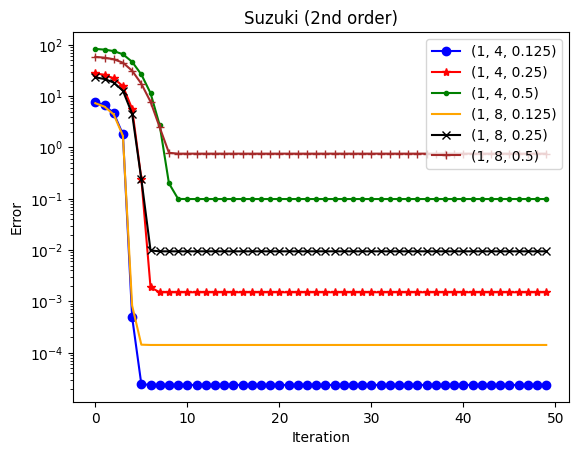

In [44]:
plot_opt_multiple(results_err, hamiltonian_params, "Suzuki (2nd order)")

### Structure ###
1. Introduction
2. Fundamentals
2.1. FH Model and reference Hamiltonian
2.2. Splitting methods
2.3. Optimizer for unitary gates

3. Contribution?
3.1 Jordan-Wigner transformation
3.2 Quantum circuit - visualization
3.3 Repo discussion
3.4 Results (visualisation)
3.5.Validation with the number operator
3.6 Implementation on a real machine

4. Outlook


How does the system behave, if the vlist_start does not corrrespond to fsim gates?
qpic for latex
quantikz

### Questions ###
- how to properly generate the number operator?
- How to implement JAX?
- thesis content

### Trivial (4) - final errors ### 
2.890459143145563e-07

1.8237759775274753e-05

0.0011500729521856101

2.2474741854239255e-06

0.0001461221974068394

0.003440140277092496


### Basic (4) - final errors ### 
5.09612618770916e-09

9.368140183596552e-07

0.00024160795516081635

8.53254960020422e-08

1.4105346792803175e-05

0.0035406343291413123

### Haddamard (4) - final errors ### 


1.2678909229180135e-06

4.803581657597533e-05

0.006883562490315853

3.963795109029888e-06

0.00014321069056677516

0.060946511312437224

### Haddamard (4) - Vlist ### 

[array([[[ 9.99997920e-01-0.00203955j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99840812e-01-0.01417536j,
          1.10694268e-04+0.01083506j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  1.93937233e-04+0.01083389j,
          9.99844161e-01-0.01393708j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99665924e-01-0.02584647j]],

       [[ 9.99996815e-01-0.00252372j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99844082e-01-0.01350996j,
          4.01350511e-04+0.01136364j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -9.27514272e-05+0.01137035j,
          9.99842391e-01-0.01363448j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99653293e-01-0.02633047j]],

       [[ 9.98595830e-01-0.05297516j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99888876e-01-0.01490759j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.99888875e-01-0.01490761j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.97051647e-01-0.07673339j]],

       [[ 9.99996815e-01-0.00252372j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99807639e-01-0.01371572j,
          7.94792791e-05+0.01401989j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  3.01092463e-04+0.01401688j,
          9.99811556e-01-0.01342716j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99653293e-01-0.02633047j]],

       [[ 9.99607186e-01-0.02802629j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98880898e-01-0.039614j  ,
          1.01186434e-03+0.02581973j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  1.04846969e-03+0.02581827j,
          9.98861703e-01-0.04009508j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.98656621e-01-0.05181654j]],

       [[ 9.99999607e-01-0.00088693j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99812366e-01-0.01539201j,
         -3.24747777e-05+0.01176083j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  3.90174949e-04+0.0117544j ,
          9.99817946e-01-0.01502522j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99695051e-01-0.02469421j]],

       [[ 9.98594198e-01-0.05300591j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99889331e-01-0.01487703j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.99889331e-01-0.01487704j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.97049323e-01-0.07676358j]],

       [[ 9.99999607e-01-0.00088693j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99813481e-01-0.01531889j,
          1.32605859e-04+0.01176084j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  2.25171487e-04+0.01175943j,
          9.99816835e-01-0.01509838j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99695051e-01-0.02469421j]],

       [[ 9.99245118e-01+0.03884834j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99280201e-01+0.02730758j,
         -6.36444577e-04+0.02632435j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -8.00585752e-04+0.02631987j,
          9.99281849e-01+0.02724721j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99886776e-01+0.01504775j]],

       [[ 9.97964840e-01+0.06376659j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98447901e-01+0.05419553j,
         -9.12084954e-04+0.01279853j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -4.76620951e-04+0.01282214j,
          9.98456233e-01+0.0540418j ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99200103e-01+0.03998942j]],

       [[ 9.96670579e-01+0.08153378j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.92977528e-01+0.11830312j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.92977530e-01+0.1183031j ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.98329135e-01+0.05778355j]],

       [[ 9.97964840e-01+0.06376658j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98329032e-01+0.05417194j,
         -9.66431367e-04+0.02009008j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -1.21071809e-03+0.02007684j,
          9.98335512e-01+0.05405238j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99200103e-01+0.03998942j]],

       [[ 9.99234683e-01+0.03911584j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99313064e-01+0.02706235j,
         -5.53455470e-04+0.02531252j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -8.14704037e-04+0.02530546j,
          9.99315862e-01+0.02695883j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99882712e-01+0.01531542j]],

       [[ 9.99998378e-01-0.00180129j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99881529e-01-0.01427445j,
          3.32107115e-04+0.0057495j ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -1.67605037e-04+0.00575665j,
          9.99880937e-01-0.01431591j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99672054e-01-0.02560829j]],

       [[ 9.98548914e-01-0.05385227j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99901581e-01-0.01402955j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.99901581e-01-0.01402957j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.96983903e-01-0.07760862j]],

       [[ 9.99998378e-01-0.00180129j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99882248e-01-0.014113j  ,
          2.36284657e-04+0.00602137j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -6.40498045e-05+0.00602567j,
          9.99877040e-01-0.01447728j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99672054e-01-0.02560829j]],

       [[ 9.99611660e-01-0.02786627j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98874711e-01-0.04023012j,
          6.22361191e-04+0.02510899j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  1.38813772e-03+0.02507831j,
          9.98891932e-01-0.03980025j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.98664903e-01-0.05165667j]],

       [[ 9.99997898e-01-0.00205025j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99682272e-01-0.01409209j,
          3.75796712e-04+0.02089563j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  2.11299722e-04+0.02089794j,
          9.99683649e-01-0.01399406j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99665648e-01-0.02585717j]],

       [[ 9.98612940e-01-0.05265166j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99883994e-01-0.0152315j ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.99883994e-01-0.01523152j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.97076452e-01-0.07641039j]],

       [[ 9.99997898e-01-0.00205025j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99845331e-01-0.01410917j,
         -6.46820783e-05+0.01049955j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  3.59591510e-04+0.01049359j,
          9.99847114e-01-0.0139823j ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99665648e-01-0.02585717j]],

       [[ 9.99997608e-01-0.00218702j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99834525e-01-0.01403921j,
          3.32497459e-04+0.01156342j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -1.07148185e-05+0.0115682j ,
          9.99838157e-01-0.01377812j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99662102e-01-0.02599388j]]]), array([[[ 9.99991282e-01-0.00417561j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99352589e-01-0.02788496j,
          2.02752427e-03+0.02264336j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -7.56117196e-04+0.02272137j,
          9.99345687e-01-0.02813122j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.98658932e-01-0.05177197j]],

       [[ 9.99991318e-01-0.00416698j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99372723e-01-0.02835003j,
          1.51559271e-03+0.02116932j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -3.27189024e-04+0.02122098j,
          9.99391369e-01-0.02768493j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.98659379e-01-0.05176336j]],

       [[ 9.94461490e-01-0.10510159j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99534267e-01-0.03051637j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.99534267e-01-0.03051637j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.88331617e-01-0.15231748j]],

       [[ 9.99991318e-01-0.00416698j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98880761e-01-0.02838118j,
          2.38129780e-03+0.03776325j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -2.61836425e-04+0.03783735j,
          9.98901915e-01-0.02762662j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.98659379e-01-0.05176336j]],

       [[ 9.98430083e-01-0.05601222j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.95574138e-01-0.07927878j,
         -1.29559412e-03+0.05045128j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.29447897e-03+0.04960466j,
          9.95524646e-01-0.07989787j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.94632003e-01-0.1034755j ]],

       [[ 9.99991057e-01-0.00422916j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99452038e-01-0.02826757j,
         -4.51734806e-03+0.01661813j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  5.43923013e-03+0.01633963j,
          9.99469438e-01-0.02764551j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.98656158e-01-0.05182546j]],

       [[ 9.94214630e-01-0.10741168j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99602494e-01-0.02819316j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.99602494e-01-0.02819317j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.87974821e-01-0.15461485j]],

       [[ 9.99991057e-01-0.00422916j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99554130e-01-0.02792755j,
          5.03220482e-03+0.00928815j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -4.50511616e-03+0.00955493j,
          9.99552313e-01-0.02799251j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.98656158e-01-0.05182546j]],

       [[ 9.96954532e-01+0.077985j  ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.97185398e-01+0.05355945j,
          5.19802788e-03+0.05220775j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -1.08191032e-02+0.05133824j,
          9.97123310e-01+0.05470316j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99536594e-01+0.03044006j]],

       [[ 9.91583684e-01+0.12946736j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.93483165e-01+0.10651541j,
         -2.57917274e-03+0.04048477j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -6.00418838e-03+0.04012006j,
          9.93635299e-01+0.10508675j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.96622473e-01+0.08211971j]],

       [[ 9.86613551e-01+0.16307575j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.72139810e-01+0.23440177j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.72139811e-01+0.23440177j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.93257604e-01+0.11592814j]],

       [[ 9.91583684e-01+0.12946736j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.93518921e-01+0.10642137j,
         -7.81833076e-03+0.03916016j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -6.03570530e-04+0.03992843j,
          9.93650452e-01+0.10518619j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.96622473e-01+0.08211971j]],

       [[ 9.96954588e-01+0.07798429j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.97126329e-01+0.0538389j ,
         -9.14972662e-03+0.05250466j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  3.41211847e-03+0.0531866j ,
          9.97094762e-01+0.05442039j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99536616e-01+0.03043934j]],

       [[ 9.99991555e-01-0.00410969j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99554753e-01-0.02836911j,
         -1.12563183e-03+0.00917729j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  1.63906864e-03+0.00909963j,
          9.99571007e-01-0.02779052j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.98662342e-01-0.05170615j]],

       [[ 9.94213400e-01-0.10742307j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99602816e-01-0.02818172j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.99602816e-01-0.02818172j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.87973051e-01-0.15462616j]],

       [[ 9.99991555e-01-0.00410969j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99449823e-01-0.02842512j,
          4.10715533e-03+0.01658899j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -3.16940429e-03+0.0167934j ,
          9.99469437e-01-0.0277269j ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.98662342e-01-0.05170615j]],

       [[ 9.98432980e-01-0.05596056j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.95581170e-01-0.07965569j,
          6.24914037e-03+0.04933612j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  1.67354455e-03+0.04970215j,
          9.95583235e-01-0.07962988j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.94637354e-01-0.10342404j]],

       [[ 9.99991051e-01-0.00423057j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98887219e-01-0.02784682j,
         -9.02801534e-04+0.03805343j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  3.02853637e-03+0.03794346j,
          9.98881998e-01-0.02803346j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.98656085e-01-0.05182687j]],

       [[ 9.94468159e-01-0.10503847j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99532328e-01-0.03057982j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.99532328e-01-0.03057982j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.88341284e-01-0.15225474j]],

       [[ 9.99991051e-01-0.00423057j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99388848e-01-0.0278633j ,
          4.37242707e-04+0.02110393j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  7.43120874e-04+0.02109538j,
          9.99383774e-01-0.02804469j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.98656085e-01-0.05182687j]],

       [[ 9.99991157e-01-0.00420541j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99343267e-01-0.02820167j,
          2.58114099e-04+0.02275158j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  1.01522204e-03+0.02273038j,
          9.99355774e-01-0.02775493j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.98657389e-01-0.05180173j]]]), array([[[ 0.99654197-0.08309094j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.99067841-0.1299999j ,
          0.00666291+0.04014866j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.0039475 +0.04050588j,
          0.99059371-0.13064374j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.98412403-0.1774821j ]],

       [[ 0.99654242-0.08308549j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.98990653-0.13507264j,
          0.00688216+0.0423447j ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.00430396+0.04268389j,
          0.99115919-0.12555086j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.98412503-0.17747656j]],

       [[ 0.95978699-0.28072929j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.9906738 -0.13625501j,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.9906738 -0.136255j  ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.9287445 -0.37072045j]],

       [[ 0.99654242-0.08308549j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.9904871 -0.12805513j,
          0.0059172 +0.05002178j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.00722164+0.04985017j,
          0.98990512-0.13247892j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.98412503-0.17747656j]],

       [[ 0.98260339-0.18571639j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.96489948-0.23802031j,
          0.02019846+0.1091208j ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.0312899 +0.10647192j,
          0.96832499-0.22367696j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.9604893 -0.27831693j]],

       [[ 0.99654153-0.0830962j ,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.9901529 -0.12902383j,
          0.00285824+0.05423949j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.01126626+0.05313345j,
          0.98983559-0.131436j  ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.98412312-0.17748711j]],

       [[ 0.95937258-0.28214225j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.99087344-0.13479548j,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.99087344-0.13479548j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.92819759-0.37208768j]],

       [[ 0.99654153-0.0830962j ,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.98737665-0.13291761j,
          0.01017156+0.08553826j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.01229611+0.08525878j,
          0.98816081-0.12695656j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.98412312-0.17748712j]],

       [[ 0.99669672+0.08121355j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.99440406+0.03601467j,
          0.00741695+0.09903786j,  0.        +0.j        ],
        [ 0.        +0.j        , -0.01406794+0.09831379j,
          0.99457251+0.03101626j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.99990288-0.01393693j]],

       [[ 0.98294677+0.18389033j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.99096592+0.13270659j,
          0.00660546+0.01821722j,  0.        +0.j        ],
        [ 0.        +0.j        , -0.01129769+0.01574361j,
          0.98982401+0.14097141j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.99597943+0.08958227j]],

       [[ 0.97066258+0.24044575j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.9177592 +0.39713732j,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.9177592 +0.39713732j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.98912773+0.14705895j]],

       [[ 0.98294677+0.18389034j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.9911795 +0.1311019j ,
         -0.01105938+0.01591193j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.00633043+0.01831461j,
          0.98959446+0.14257389j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.99597943+0.08958227j]],

       [[ 0.99669672+0.08121355j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.99444196+0.03495263j,
         -0.01560068+0.0980822j ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.00896181+0.09890998j,
          0.99453883+0.03207841j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.99990288-0.01393692j]],

       [[ 0.99654153-0.08309618j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.98798918-0.1282853j ,
          0.01313531+0.08513356j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.00932853+0.08563433j,
          0.9875545 -0.13158967j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.98412313-0.1774871j ]],

       [[ 0.95937259-0.28214224j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.99087344-0.1347955j ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.99087344-0.1347955j ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.92819759-0.37208766j]],

       [[ 0.99654153-0.08309618j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.99079576-0.12399059j,
          0.0112704 +0.05313254j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.002854  +0.05423969j,
          0.98915491-0.13646422j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.98412313-0.1774871j ]],

       [[ 0.98260339-0.18571642j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.96465604-0.23900502j,
          0.03193077+0.1062815j ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.01954072+0.10924052j,
          0.96855277-0.22268857j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.96048929-0.27831695j]],

       [[ 0.99654242-0.08308549j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.99016434-0.13052734j,
          0.00699484+0.0498825j ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.00614463+0.04999435j,
          0.99023275-0.13000736j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.98412503-0.17747657j]],

       [[ 0.95978699-0.28072929j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.9906738 -0.136255j  ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.9906738 -0.136255j  ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.9287445 -0.37072046j]],

       [[ 0.99654242-0.0830855j ,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.98970345-0.13655269j,
          0.00428021+0.04268628j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.00690573+0.04234087j,
          0.99134582-0.12406864j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.98412503-0.17747656j]],

       [[ 0.99654197-0.08309094j,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.99061728-0.13046489j,
          0.00392846+0.04050773j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.00668177+0.04014552j,
          0.99065493-0.13017875j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.98412403-0.1774821j ]]]), array([[[ 9.99992813e-01+0.00379122j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99745712e-01-0.01986764j,
          2.23251926e-04+0.01066483j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  2.01030667e-04+0.01066527j,
          9.99744974e-01-0.01990476j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99039672e-01-0.04381478j]],

       [[ 9.99992924e-01+0.00376191j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99743902e-01-0.01990292j,
          1.16335550e-04+0.01076987j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  3.11398305e-04+0.01076599j,
          9.99745750e-01-0.01980988j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99038388e-01-0.04384404j]],

       [[ 9.97425093e-01-0.071716j  ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99992516e-01+0.00386896j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.99992515e-01+0.00386904j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.92881173e-01-0.11910909j]],

       [[ 9.99992924e-01+0.00376191j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99705223e-01-0.01993909j,
          3.35645718e-04+0.01384873j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  2.14448851e-04+0.01385114j,
          9.99708631e-01-0.01976747j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99038388e-01-0.04384404j]],

       [[ 9.99760554e-01-0.02188228j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98604813e-01-0.04589909j,
          1.20859790e-03+0.02608144j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  1.19392243e-03+0.02608211j,
          9.98596162e-01-0.04608691j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.97585565e-01-0.06944811j]],

       [[ 9.99991064e-01+0.0042276j ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99720227e-01-0.02038162j,
          3.87360970e-04+0.01199613j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  1.00466419e-04+0.01200196j,
          9.99722647e-01-0.02026257j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99058697e-01-0.0433788j ]],

       [[ 9.97407764e-01-0.07195659j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99991549e-01+0.00411114j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.99991549e-01+0.00411122j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.92852154e-01-0.11935074j]],

       [[ 9.99991064e-01+0.0042276j ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99591241e-01-0.02030287j,
          3.87151462e-04+0.02012448j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  4.31004559e-04+0.02012359j,
          9.99590564e-01-0.02033616j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99058697e-01-0.0433788j ]],

       [[ 9.98993031e-01+0.04486562j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99443253e-01+0.0212021j ,
         -7.15960259e-04+0.02575153j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -3.79669722e-04+0.02575869j,
          9.99440864e-01+0.02131446j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99996248e-01-0.00273934j]],

       [[ 9.97526860e-01+0.0702863j ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98846422e-01+0.04767315j,
         -2.63222570e-04+0.00574688j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -2.84412022e-04+0.00574587j,
          9.98853806e-01+0.04751819j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99741815e-01+0.02272232j]],

       [[ 9.98118475e-01+0.06131484j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.90375586e-01+0.13840592j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.90375576e-01+0.13840599j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99905638e-01+0.01373734j]],

       [[ 9.97526860e-01+0.0702863j ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98846420e-01+0.04767841j,
         -2.96047933e-04+0.00570176j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -2.47445376e-04+0.00570408j,
          9.98854305e-01+0.04751295j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99741815e-01+0.02272232j]],

       [[ 9.98992146e-01+0.04488533j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99445293e-01+0.0211883j ,
         -2.98613431e-04+0.0256919j ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -7.93090277e-04+0.02568139j,
          9.99443155e-01+0.02128891j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99996302e-01-0.00271961j]],

       [[ 9.99991172e-01+0.00420192j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99590550e-01-0.02026369j,
          3.04323300e-04+0.02019958j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  5.15778961e-04+0.02019529j,
          9.99589327e-01-0.02032394j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99057583e-01-0.04340445j]],

       [[ 9.97408969e-01-0.0719399j ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99991618e-01+0.00409441j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.99991618e-01+0.00409448j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.92854151e-01-0.11933413j]],

       [[ 9.99991172e-01+0.00420192j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99721779e-01-0.02025658j,
          3.21922322e-04+0.01208021j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  1.68647321e-04+0.01208332j,
          9.99720162e-01-0.02033622j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99057583e-01-0.04340445j]],

       [[ 9.99759247e-01-0.02194191j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98599976e-01-0.04599399j,
          1.04520402e-03+0.02610649j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  1.35581487e-03+0.0260922j ,
          9.98605549e-01-0.04587283j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.97581421e-01-0.06950761j]],

       [[ 9.99992873e-01+0.0037755j ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99706826e-01-0.01988582j,
          2.36797792e-04+0.01381158j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  3.12119212e-04+0.01381009j,
          9.99707579e-01-0.01984793j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99038983e-01-0.04383046j]],

       [[ 9.97424803e-01-0.07172003j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99992500e-01+0.00387301j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.99992500e-01+0.00387308j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.92880692e-01-0.11911311j]],

       [[ 9.99992873e-01+0.0037755j ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99743625e-01-0.0199362j ,
          2.30717629e-04+0.01073211j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  1.95898656e-04+0.0107328j ,
          9.99746257e-01-0.01980377j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99038983e-01-0.04383046j]],

       [[ 9.99992678e-01+0.0038267j ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99745089e-01-0.01989811j,
          2.48428280e-04+0.0106659j ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  1.76673824e-04+0.01066733j,
          9.99744149e-01-0.01994524j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99041226e-01-0.04377932j]]]), array([[[ 9.99970258e-01+0.00771247j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99022856e-01-0.03921763j,
          7.99411182e-04+0.02036349j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  8.26717880e-04+0.0203624j ,
          9.98969279e-01-0.04055945j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.96171944e-01-0.08741543j]],

       [[ 9.99970253e-01+0.00771315j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98948126e-01-0.0409315j ,
          8.73989756e-04+0.02065163j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  7.75358394e-04+0.02065556j,
          9.99031418e-01-0.0388455j ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.96172003e-01-0.08741476j]],

       [[ 9.89984284e-01-0.14117761j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99982979e-01+0.00583454j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.99982979e-01+0.00583455j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.72074028e-01-0.23467442j]],

       [[ 9.99970253e-01+0.00771315j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98903635e-01-0.039656j  ,
          1.07210479e-03+0.02485519j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.12924973e-04+0.02486154j,
          9.98885535e-01-0.04010932j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.96172003e-01-0.08741476j]],

       [[ 9.99027800e-01-0.04408463j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.94138550e-01-0.09380304j,
          4.89020055e-03+0.05353147j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  4.95651984e-03+0.05352537j,
          9.94570058e-01-0.08911154j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.90308072e-01-0.13888817j]],

       [[ 9.99970257e-01+0.00771261j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98922750e-01-0.03698722j,
          9.88191802e-04+0.0280055j ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  1.24782004e-03+0.02799513j,
          9.98691686e-01-0.04277419j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.96171957e-01-0.08741529j]],

       [[ 9.89505971e-01-0.14449198j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99957830e-01+0.00918356j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.99957830e-01+0.00918356j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.71282637e-01-0.23792864j]],

       [[ 9.99970257e-01+0.00771261j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98209819e-01-0.03781093j,
          1.40527119e-03+0.04631971j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  2.29226261e-03+0.04628429j,
          9.98046689e-01-0.04189648j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.96171957e-01-0.08741529j]],

       [[ 9.95956499e-01+0.08983681j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.97852234e-01+0.04112863j,
         -1.50714576e-03+0.0509616j ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -2.80829874e-03+0.05090648j,
          9.97755526e-01+0.04341145j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99986052e-01-0.00528157j]],

       [[ 9.89967549e-01+0.14129491j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.95497938e-01+0.09463646j,
         -5.72086840e-04+0.00524108j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -4.19094677e-04+0.00525553j,
          9.95616401e-01+0.09338193j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.98917692e-01+0.04651285j]],

       [[ 9.92730910e-01+0.12035506j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.61120786e-01+0.2761283j ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.61120786e-01+0.27612829j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99677069e-01+0.02541176j]],

       [[ 9.89967549e-01+0.14129491j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.95551528e-01+0.09407103j,
         -5.75653485e-04+0.00524069j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -4.15517283e-04+0.00525581j,
          9.95563203e-01+0.0939474j ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.98917692e-01+0.04651285j]],

       [[ 9.95956535e-01+0.08983641j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.97785363e-01+0.04272022j,
         -1.40125431e-03+0.05096459j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -2.91410482e-03+0.0509005j ,
          9.97823469e-01+0.0418207j ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99986050e-01-0.00528198j]],

       [[ 9.99970257e-01+0.00771262j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98083771e-01-0.04100359j,
          1.23549366e-03+0.04632456j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  2.46188823e-03+0.04627559j,
          9.98175591e-01-0.03870399j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.96171957e-01-0.08741528j]],

       [[ 9.89505975e-01-0.14449196j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99957830e-01+0.00918354j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.99957830e-01+0.00918353j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.71282643e-01-0.23792862j]],

       [[ 9.99970257e-01+0.00771262j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98734873e-01-0.04175368j,
          8.31822740e-04+0.02801057j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  1.40409599e-03+0.02798772j,
          9.98884434e-01-0.03800795j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.96171957e-01-0.08741528j]],

       [[ 9.99027805e-01-0.04408453j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.94555605e-01-0.08927271j,
          5.25223287e-03+0.05349716j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  4.59431353e-03+0.05355767j,
          9.94153719e-01-0.09364214j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.90308086e-01-0.13888807j]],

       [[ 9.99970253e-01+0.00771315j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98848291e-01-0.04102635j,
          9.22717916e-04+0.02486118j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  1.06231415e-03+0.02485561j,
          9.98939621e-01-0.03873892j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.96172003e-01-0.08741476j]],

       [[ 9.89984286e-01-0.1411776j ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99982979e-01+0.00583453j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.99982979e-01+0.00583454j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.72074030e-01-0.23467441j]],

       [[ 9.99970253e-01+0.00771315j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.98978548e-01-0.04018219j,
          7.96479313e-04+0.02065476j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  8.52870972e-04+0.02065251j,
          9.99002001e-01-0.03959481j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.96172003e-01-0.08741476j]],

       [[ 9.99970259e-01+0.00771241j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99017534e-01-0.03935297j,
          8.24012600e-04+0.02036251j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  8.02114906e-04+0.02036339j,
          9.98974768e-01-0.04042403j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.96171939e-01-0.08741549j]]]), array([[[ 9.90957518e-01-0.13417599j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.95356599e-01-0.08070207j,
          4.10595982e-03+0.05230255j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  4.21749491e-03+0.05229367j,
          9.95592969e-01-0.07773174j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99665784e-01-0.02585189j]],

       [[ 9.91010979e-01-0.13378057j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.95775300e-01-0.07595844j,
          3.67441314e-03+0.05146227j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  4.55072166e-03+0.05139219j,
          9.95191680e-01-0.08325656j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99676015e-01-0.02545317j]],

       [[ 8.76235408e-01-0.48188329j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.96675168e-01+0.08147767j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.96675174e-01+0.08147759j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.23347168e-01-0.38396615j]],

       [[ 9.91010979e-01-0.13378057j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.91407093e-01-0.07548436j,
          6.17234280e-03+0.10665829j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  1.08576429e-02+0.10628358j,
          9.90802633e-01-0.08304249j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99676015e-01-0.02545317j]],

       [[ 9.72658055e-01-0.23224192j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.60128506e-01-0.18346797j,
          4.15435189e-02+0.20680158j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  3.68199476e-02+0.2076946j ,
          9.60839950e-01-0.17970485j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.92115807e-01-0.12532448j]],

       [[ 9.90985134e-01-0.13397188j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.90982637e-01-0.07954067j,
          1.01307358e-02+0.10735019j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  7.01798971e-03+0.10759852j,
          9.91058669e-01-0.07858766j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99671083e-01-0.02564617j]],

       [[ 9.90390370e-01+0.13830009j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  8.47267981e-01-0.53116567j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          8.47267939e-01-0.53116574j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.69539503e-01+0.244935j  ]],

       [[ 9.90985134e-01-0.13397188j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.88564510e-01-0.08047707j,
         -2.56845693e-02-0.12491578j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  5.55347425e-03-0.12740804j,
          9.88819255e-01-0.07728409j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99671083e-01-0.02564617j]],

       [[ 9.99623284e-01+0.02744614j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.95712642e-01+0.09119551j,
          3.59258616e-03-0.01506016j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -9.14228904e-04-0.01545572j,
          9.96375027e-01+0.08364861j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.90742274e-01+0.1357562j ]],

       [[ 9.91005597e-01+0.13382043j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.76998240e-01+0.18156055j,
         -7.37685349e-03+0.1116055j ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -3.41231465e-02+0.10651674j,
          9.75410565e-01+0.1899053j ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.70632521e-01+0.24056706j]],

       [[ 7.98345076e-01+0.60220025j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.99987657e-01+0.00496857j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.99987657e-01+0.00496849j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  7.28297508e-01+0.68526107j]],

       [[ 9.91005597e-01+0.13382043j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.77135198e-01+0.18147608j,
         -3.36907257e-02+0.10553754j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -7.41947000e-03+0.11053592j,
          9.75506937e-01+0.19003415j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.70632521e-01+0.24056706j]],

       [[ 9.99618750e-01+0.02761079j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.95704748e-01+0.0912804j ,
         -8.40890453e-04-0.01546729j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  3.51741478e-03-0.01508549j,
          9.96409515e-01+0.08323541j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.90719900e-01+0.13591939j]],

       [[ 9.91000468e-01-0.13385841j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.88771991e-01-0.08077871j,
          5.46060984e-03-0.12559829j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        , -2.53341356e-02-0.12313786j,
          9.89054272e-01-0.07724569j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99674013e-01-0.0255317j ]],

       [[ 9.90431106e-01+0.13800806j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  8.47424563e-01-0.53091582j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          8.47424521e-01-0.53091589j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.69611682e-01+0.24464911j]],

       [[ 9.91000468e-01-0.13385841j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.91030293e-01-0.07964479j,
          6.84342621e-03+0.10709264j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  1.02473456e-02+0.10682068j,
          9.91104228e-01-0.0787194j ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99674013e-01-0.0255317j ]],

       [[ 9.72456264e-01-0.23308543j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.60183331e-01-0.1826175j ,
          3.68237384e-02+0.20818942j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  4.13610421e-02+0.20733568j,
          9.60892197e-01-0.17885012j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.92006739e-01-0.1261849j ]],

       [[ 9.91013255e-01-0.1337637j ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.91407118e-01-0.07574701j,
          1.09879361e-02+0.1060829j ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  6.01543585e-03+0.10648066j,
          9.90841583e-01-0.08281691j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99676449e-01-0.02543616j]],

       [[ 8.76266193e-01-0.48182731j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.96680371e-01+0.08141399j,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          9.96680378e-01+0.08141391j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.23371697e-01-0.38390716j]],

       [[ 9.91013255e-01-0.1337637j ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.95762645e-01-0.07607105j,
          4.43892570e-03+0.05148055j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  3.80058511e-03+0.05153161j,
          9.95194250e-01-0.08317725j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99676449e-01-0.02543616j]],

       [[ 9.91007863e-01-0.13380365j,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  9.95341769e-01-0.08123899j,
          4.03846544e-03+0.05175597j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  4.23658012e-03+0.05174013j,
          9.95604946e-01-0.07794743j,  0.00000000e+00+0.j        ],
        [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
          0.00000000e+00+0.j        ,  9.99675427e-01-0.02547628j]]])]

In [ ]:
np.linalg.norm(number_operator(L) @ reference_hamiltonian(1, 4, 0.125, 4) - reference_hamiltonian(1, 4, 0.125, 4) @ number_operator(L))

H.shape: (256, 256)
H.shape: (256, 256)


0.0

In [12]:
print((results_err[0] + 16) / 16)
print((results_err[1] + 256) / 256)
print((results_err[2] + 4096) / 4096)

8.318514173932812e-06
6.475877597611479e-06
9.713610479855639e-06
